## Kaggle Housing 가격 예측 프로젝트 보고서

### 1. 프로젝트 목표
#### 회귀모델 예측정확도가 기준 이상 높게 나왔는가?
 - 캐글 리더보드 Private Score 110,000 이하 달성을 목표
#### 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?
- 데이터 전처리 및 피처 엔지니어링
 -- train과 test 데이터를 concat하여 동일 전처리를 수행
 -- date 컬럼을 year, month로 분해.
 -- zipcode는 범주형(category)으로 변환.
 -- 왜도가 큰 면적 관련 피처에 log1p 변환을 적용.
 -- 타깃 변수 price에도 log1p 변환을 적용하여 RMSLE 성능을 개선함.

#### 모델 학습 및 최적화
 - 모델: LightGBM Regressor
 - 검증 방법: 5-Fold KFold 교차검증
 - 평가 지표: RMSLE
  -- GridSearchCV를 활용하여 주요 하이퍼파라미터를 최적화함.

#### 결과
- Public Score: 109,136.76
- Private Score: 109,724.38
 -- 목표였던 Private Score 110,000 이하를 달성.

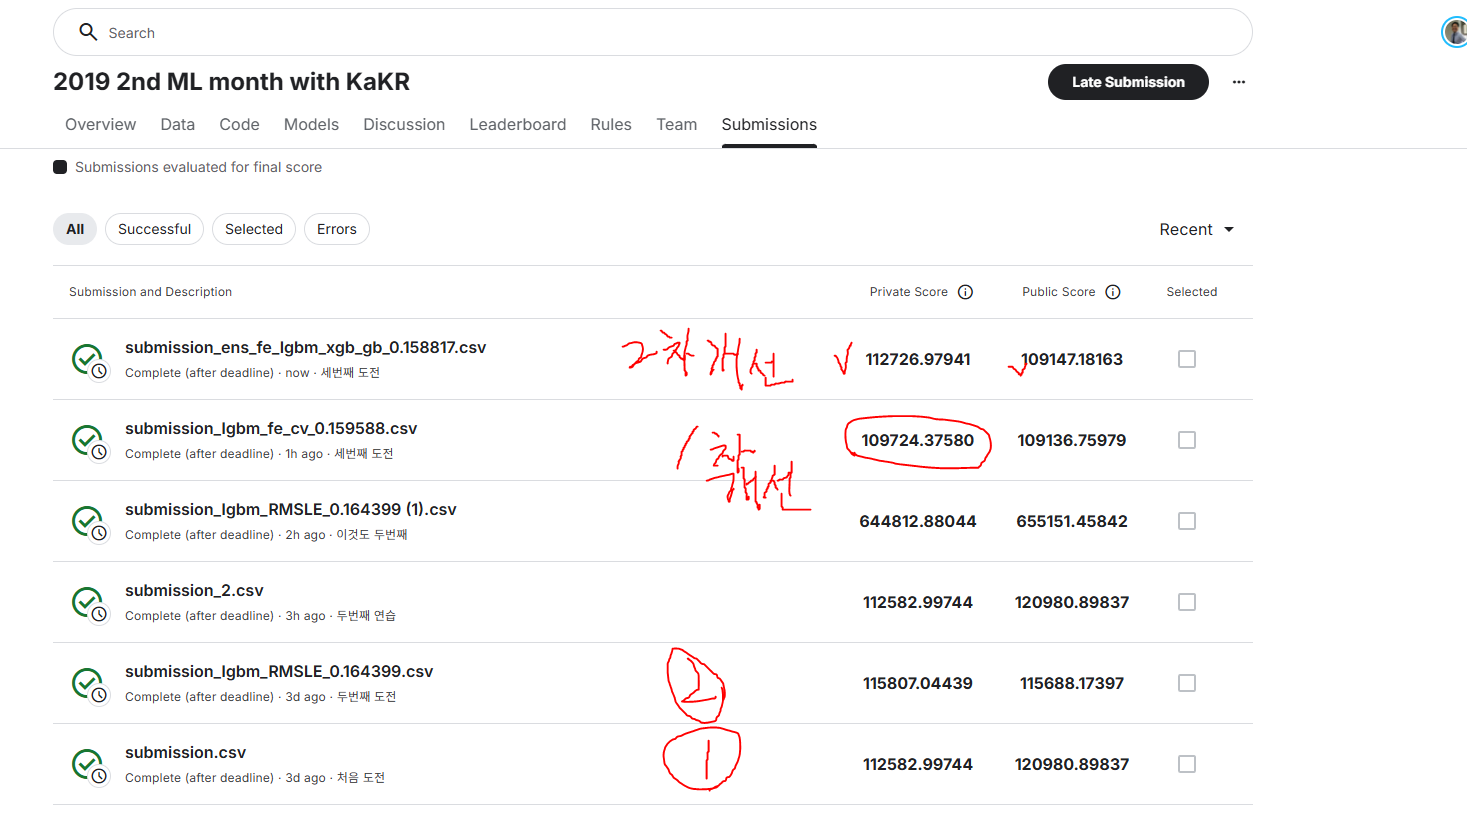

### A 라이브러리 및 데이터 로드, 타겟 분리

In [69]:
import os
from os.path import join
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer

from lightgbm import LGBMRegressor

# -------------------------
# 1) 데이터 로드
# -------------------------
data_dir = os.path.join(os.getenv('HOME'), 'work/kaggle_kakr_housing/data')
train_path = join(data_dir, 'train.csv')
test_path  = join(data_dir, 'test.csv')

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

# -------------------------
# 2) 타깃 분리 + id 저장
# -------------------------
y = train['price'].copy()
train_id = train['id'].copy()
test_id = test['id'].copy()

train.drop(['price'], axis=1, inplace=True)

print("train:", train.shape, "test:", test.shape, "y:", y.shape)

train: (15035, 20) test: (6468, 20) y: (15035,)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

### B 피처 엔지니어링 + train/test 분리

In [70]:

# -------------------------
# 3) train+test 합쳐서 동일 전처리
# train/test 분리 후 각각 전처리 → 분포 불일치 위험, Baseline처럼 concat 후 동일 전처리가 안정적
# -------------------------
all_data = pd.concat([train, test], axis=0, ignore_index=True)

# -------------------------
# 4) date 피처 엔지니어링 (연/월)
# -------------------------
# date 예: "20141013T000000"
all_data['date'] = all_data['date'].astype(str)
all_data['year'] = all_data['date'].str[:4].astype(int)
all_data['month'] = all_data['date'].str[4:6].astype(int)
all_data.drop(['date'], axis=1, inplace=True)

# -------------------------
# 5) id 제거 (모델에 불필요)
# -------------------------
all_data.drop(['id'], axis=1, inplace=True)

# -------------------------
# 6) zipcode는 범주형 처리 (중요)
# category 처리
# -------------------------
# LightGBM은 category를 잘 처리합니다.
all_data['zipcode'] = all_data['zipcode'].astype('category')

# -------------------------
# 7) 왜도(skew) 큰 피처 log1p 변환
# -------------------------
skew_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
             'sqft_living15', 'sqft_lot15', 'bedrooms']

for c in skew_cols:
    # 0 이하가 있을 가능성이 거의 없지만, 안전하게 처리
    all_data[c] = np.log1p(all_data[c].astype(float))

# -------------------------
# 8) 타깃 log 변환 (RMSLE에 유리)
# -------------------------
y_log = np.log1p(y)

# -------------------------
# 9) 다시 train/test로 분리
# -------------------------
X_train = all_data.iloc[:len(y), :].copy()
X_test  = all_data.iloc[len(y):, :].copy()

print("X_train:", X_train.shape, "X_test:", X_test.shape)

X_train: (15035, 20) X_test: (6468, 20)


### C GridSearchCV (메모리 안전 설정)

In [71]:

# -------------------------
# 10) RMSLE scorer 정의 (GridSearch용)
# -------------------------
# RMSLE scorer (log1p 스케일을 expm1로 원복 후 RMSLE 계산)
def rmsle(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# -------------------------
# 11) LightGBM + GridSearch (CV 기반)
# -------------------------

# LightGBM 모델 (내부 스레드 제한: n_jobs=1로 안전하게)
model = LGBMRegressor(
    random_state=42,
    n_estimators=800,
    learning_rate=0.05,
    n_jobs=1
)

# ✅ 조합 수를 줄인 안전 param_grid (8조합 → 5-fold면 40 fits)
param_grid = {
    'max_depth': [-1, 10],
    'num_leaves': [31, 63],
    'min_child_samples': [20, 50],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# ✅ GridSearch 병렬 제한: n_jobs=1 (메모리 안정)
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=rmsle_scorer,
    cv=cv,
    n_jobs=1,
    verbose=1
)

grid.fit(X_train, y_log)

print("Best params:", grid.best_params_)
print("Best CV score (neg RMSLE):", grid.best_score_)
print("Best CV RMSLE:", -grid.best_score_)

best_model = grid.best_estimator_


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2299
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 20
[LightGBM] [Info] Start training from score 13.047364
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2329
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 20
[LightGBM] [Info] Start training from score 13.049396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

### D 예측 + 제출 파일 저장

In [72]:

# -------------------------
# 12) 테스트 예측 + 원복
# -------------------------
pred_log = best_model.predict(X_test)
pred = np.expm1(pred_log)

# -------------------------
# 13) 제출 파일 만들기
# -------------------------
# sample_submission 로드
sample_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(sample_path)

submission['price'] = pred

out_path = join(data_dir, f"submission_lgbm_fe_cv_{-grid.best_score_:.6f}.csv")
submission.to_csv(out_path, index=False)

print("Saved:", out_path)
submission.head()

Saved: /home/jovyan/work/kaggle_kakr_housing/data/submission_lgbm_fe_cv_0.159588.csv


,id,price
0,15035,5.340297e+05
1,15036,4.836926e+05
2,15037,1.373667e+06
3,15038,3.045742e+05
4,15039,3.310512e+05


# 캐글 제출 결과
 ## 목표 달성 110,000 이하 달성

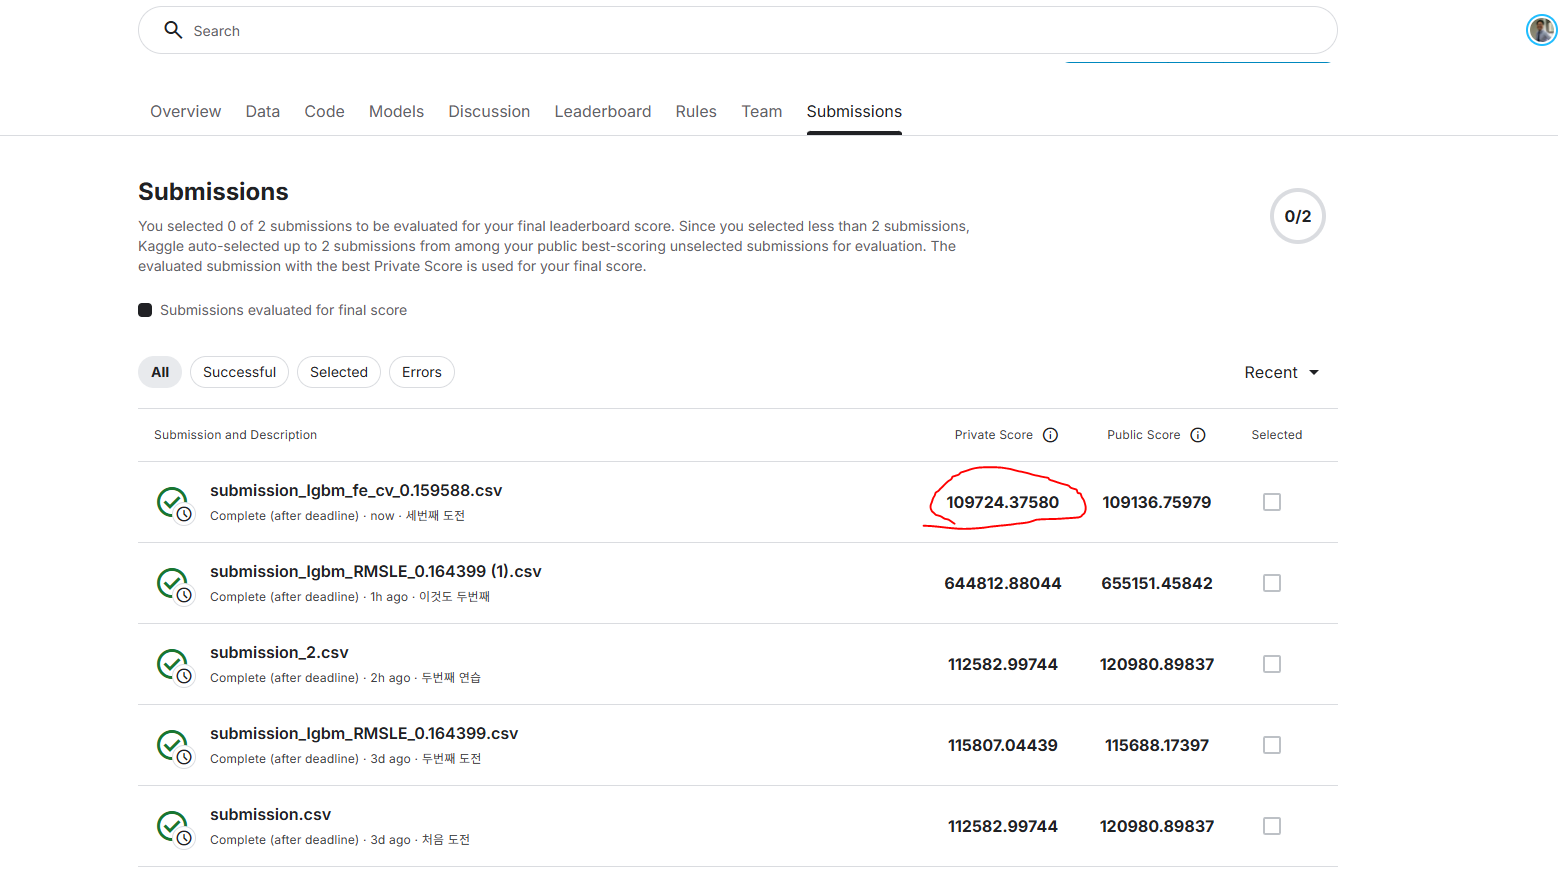


## 2차 개선

In [9]:
import lightgbm
import xgboost
xgboost.__version__, lightgbm.__version__

('3.1.3', '4.6.0')

### A 로드 + 타깃 분리 

In [10]:
import os
from os.path import join
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

# 1) 데이터 로드
data_dir = os.path.join(os.getenv('HOME'), 'work/kaggle_kakr_housing/data')
train_path = join(data_dir, 'train.csv')
test_path  = join(data_dir, 'test.csv')
sample_path = join(data_dir, 'sample_submission.csv')

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)
submission = pd.read_csv(sample_path)

# 2) 타깃 분리
y = train['price'].copy()
train.drop(['price'], axis=1, inplace=True)

print("train:", train.shape, "test:", test.shape, "y:", y.shape)

train: (15035, 20) test: (6468, 20) y: (15035,)


### B 피처 엔지니어링(전처리) + train/test 분리

In [11]:
# 3) train+test concat 후 동일 전처리
all_data = pd.concat([train, test], axis=0, ignore_index=True)

# 4) date -> year/month
all_data['date'] = all_data['date'].astype(str)
all_data['year']  = all_data['date'].str[:4].astype(int)
all_data['month'] = all_data['date'].str[4:6].astype(int)
all_data.drop(['date'], axis=1, inplace=True)

# 5) id 제거
if 'id' in all_data.columns:
    all_data.drop(['id'], axis=1, inplace=True)

# 6) zipcode category
all_data['zipcode'] = all_data['zipcode'].astype('category')

# 7) skew log1p
skew_cols = [
    'bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above',
    'sqft_basement', 'sqft_lot15', 'sqft_living15'
]
for c in skew_cols:
    all_data[c] = np.log1p(all_data[c].astype(float))

# 8) train/test 분리
train_len = len(y)
X_train = all_data.iloc[:train_len, :].copy()
X_test  = all_data.iloc[train_len:, :].copy()

# 9) y log1p
y_log = np.log1p(y)

print("X_train:", X_train.shape, "X_test:", X_test.shape)


X_train: (15035, 20) X_test: (6468, 20)


### C (메모리 안전) LGBM GridSearch + 학습

In [12]:
import sys, warnings
from collections import deque

# -------------------------
# (A) 출력 30줄 제한(노트북에서도 안전하게)
# -------------------------
class LimitStdout:
    def __init__(self, max_lines=30):
        self.max_lines = max_lines
        self._old_write = None
        self._buf = deque()
        self._line_buf = ""

    def write(self, s):
        # 줄 단위로 모아서 최대 max_lines만 출력
        self._line_buf += s
        while "\n" in self._line_buf:
            line, self._line_buf = self._line_buf.split("\n", 1)
            self._buf.append(line)
            if len(self._buf) > self.max_lines:
                self._buf.popleft()
        # 실제 출력은 하지 않음(마지막에 한번에 출력)

    def flush(self):
        pass

    def __enter__(self):
        self._old = sys.stdout
        sys.stdout = self
        return self

    def __exit__(self, exc_type, exc, tb):
        sys.stdout = self._old
        # 마지막에 최대 max_lines만 출력
        for line in self._buf:
            self._old.write(line + "\n")
        if self._line_buf.strip():
            self._old.write(self._line_buf + "\n")


warnings.filterwarnings("ignore")  # 경고 줄이기


# -------------------------
# 10) RMSLE scorer
# -------------------------
def rmsle(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)


# -------------------------
# 11-A) LightGBM 튜닝 (출력 최소화 + 메모리 안정)
# -------------------------
base_lgbm = LGBMRegressor(
    random_state=42,
    n_estimators=600,
    learning_rate=0.03,
    n_jobs=1,
    verbose=-1,          # ✅ LightGBM 로그 최소화
)

param_grid = {
    'max_depth': [-1, 10],
    'num_leaves': [31, 63],
    'min_child_samples': [20, 50],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_alpha': [0.0, 0.1],
    'reg_lambda': [0.0, 0.1],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=base_lgbm,
    param_grid=param_grid,
    scoring=rmsle_scorer,
    cv=cv,
    n_jobs=1,
    verbose=0        # ✅ "Fitting 5 folds..." 같은 출력 제거
)

with LimitStdout(max_lines=30):  # ✅ 혹시 남는 출력이 있어도 30줄만
    grid.fit(X_train, y_log)

best_lgbm = grid.best_estimator_
print("Best LGBM params:", grid.best_params_)
print("Best CV RMSLE:", -grid.best_score_)


# -------------------------
# 11-B) XGB / GBoost 학습 (zipcode category 문제 해결 + 출력 최소화)
# -------------------------
# ✅ XGB는 category를 그대로 못 먹는 환경이 많아서 codes로 변환한 복사본 사용
X_train_xgb = X_train.copy()
X_test_xgb  = X_test.copy()
if str(X_train_xgb['zipcode'].dtype) == 'category':
    X_train_xgb['zipcode'] = X_train_xgb['zipcode'].cat.codes.astype(int)
    X_test_xgb['zipcode']  = X_test_xgb['zipcode'].cat.codes.astype(int)

xgb = XGBRegressor(
    random_state=42,
    n_estimators=800,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    objective='reg:squarederror',
    tree_method='hist',
    n_jobs=1,
    verbosity=0,      # ✅ XGBoost 로그 최소화
)

gboost = GradientBoostingRegressor(random_state=42)

with LimitStdout(max_lines=30):
    xgb.fit(X_train_xgb, y_log)
    gboost.fit(X_train, y_log)

Best LGBM params: {'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'num_leaves': 63, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}
Best CV RMSLE: 0.1588172826329387


### D 앙상블 예측 + 제출 저장

In [13]:
# 13) 예측 (log 스케일) + 앙상블
pred_lgbm_log = best_lgbm.predict(X_test)
pred_xgb_log  = xgb.predict(X_test)
pred_gb_log   = gboost.predict(X_test)

# 가중치 (필요하면 조정)
w_lgbm, w_xgb, w_gb = 0.5, 0.3, 0.2
pred_ens_log = (w_lgbm * pred_lgbm_log) + (w_xgb * pred_xgb_log) + (w_gb * pred_gb_log)

# 원복
pred = np.expm1(pred_ens_log)

# 14) 제출 저장
submission['price'] = pred
out_path = join(data_dir, f"submission_ens_fe_lgbm_xgb_gb_{-grid.best_score_:.6f}.csv")
submission.to_csv(out_path, index=False)
print("Saved:", out_path)

submission.head()

Saved: /home/jovyan/work/kaggle_kakr_housing/data/submission_ens_fe_lgbm_xgb_gb_0.158817.csv


,id,price
0,15035,5.179618e+05
1,15036,4.686641e+05
2,15037,1.381410e+06
3,15038,3.050182e+05
4,15039,3.288165e+05


# 2차 개선 결과

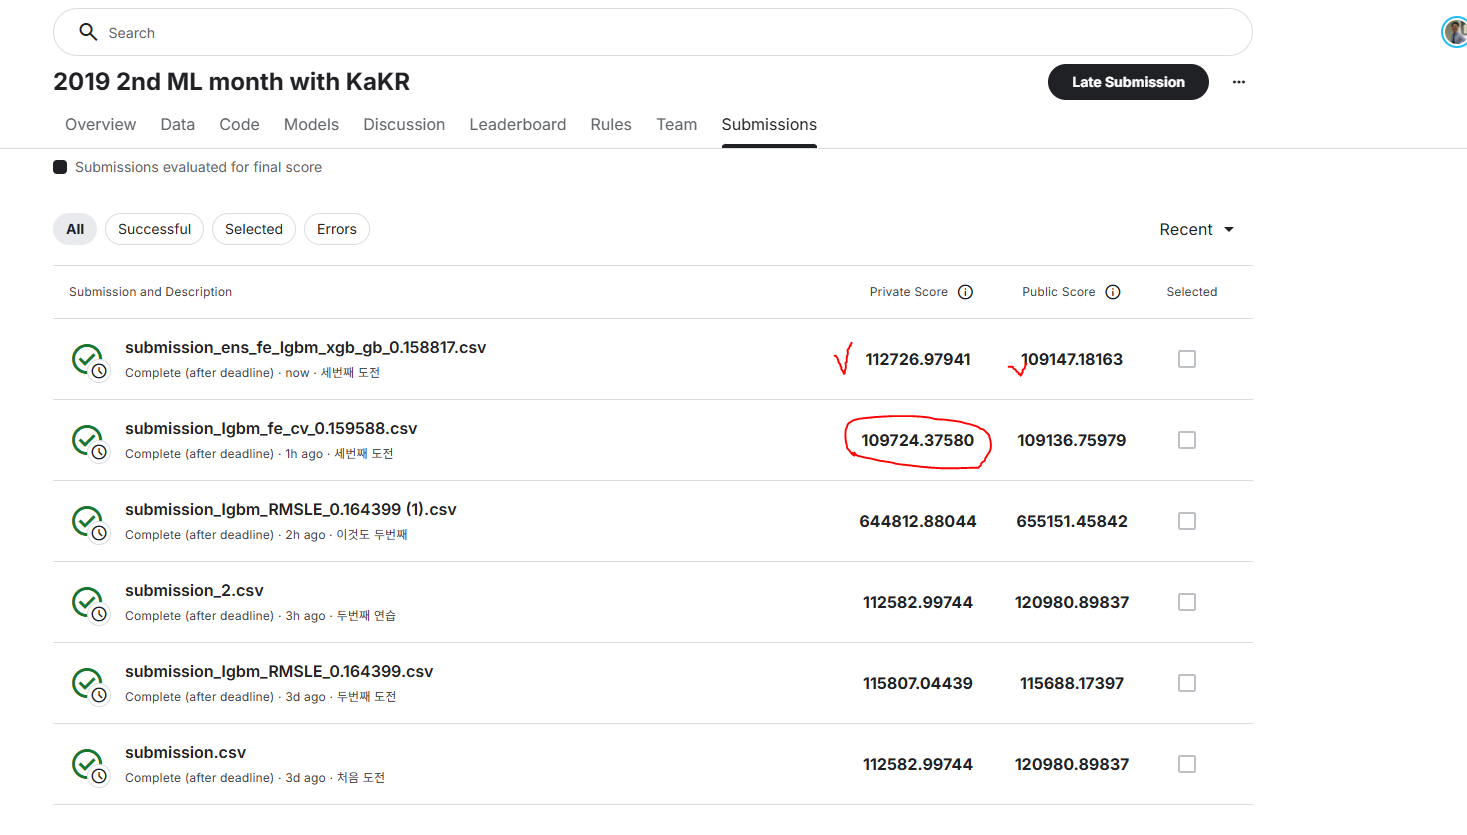